In [2]:
#required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import nlp
import tensorflow as tf
from transformers import pipeline, AutoTokenizer

#setting to avoid truncation of the text rows

pd.set_option('display.max_colwidth', None)

In [3]:
#extracting the data for the hate df and violence df

data3 = pd.read_csv('c:/Data_Science/IH_Notebooks/IH_NLP_Final_Project/Train.csv')
violence_df = data3.copy()

print(violence_df.head(3))

      Tweet_ID  \
0  ID_0022DWKP   
1  ID_00395QYM   
2  ID_003EOSSF   

                                                                                                                                                                                                         tweet  \
0  Had a dream i got raped last night. By a guy i work with. Actually a guy i smoked with once at my house but he was doing too much tryna be sexual and it wasn’t even like that for me just wanted to smoke.   
1                                                                                                         he thought the word raped means sex and told me “i saw our dogs raping eachother” and i was like wtf   
2                                                                                                     She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 MOLESTED HE IN JAIL ON NOTHER CHARGE SO SHE NOT SAYING WORD   

              type  
0  sexual_violence  
1  sexual_violence  
2  sexual_violence  


In [4]:
#dropping unnecessary columns


violence_df = violence_df.drop(columns='Tweet_ID')

print("First 3 rows of violence_df after column drop: \n", violence_df.head(3))

First 3 rows of violence_df after column drop: 
                                                                                                                                                                                                          tweet  \
0  Had a dream i got raped last night. By a guy i work with. Actually a guy i smoked with once at my house but he was doing too much tryna be sexual and it wasn’t even like that for me just wanted to smoke.   
1                                                                                                         he thought the word raped means sex and told me “i saw our dogs raping eachother” and i was like wtf   
2                                                                                                     She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 MOLESTED HE IN JAIL ON NOTHER CHARGE SO SHE NOT SAYING WORD   

              type  
0  sexual_violence  
1  sexual_violence  
2  sexual_violence  


In [5]:
violence_df = violence_df.rename(columns={'tweet': 'text', 'type': 'label'})

In [6]:
import re

def clean_text(text):

    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\brt\b', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

#cleaning the text


violence_df['clean_text'] = violence_df['text'].apply(clean_text)


In [7]:


violence_df = violence_df.drop(columns='text')

#moving the label column back on the right of the df

violence_label_placeholder = violence_df.pop('label')

violence_df['label'] = violence_label_placeholder

#Checking the results

print("First 3 rows of violence_df: \n", violence_df.head(3))



First 3 rows of violence_df: 
                                                                                                                                                                                                 clean_text  \
0  had a dream i got raped last night by a guy i work with actually a guy i smoked with once at my house but he was doing too much tryna be sexual and it wasnt even like that for me just wanted to smoke   
1                                                                                                       he thought the word raped means sex and told me i saw our dogs raping eachother and i was like wtf   
2                                                                                                     she not talking to me i was raped by men molested he in jail on nother charge so she not saying word   

             label  
0  sexual_violence  
1  sexual_violence  
2  sexual_violence  


In [8]:
violence_df = violence_df.rename(columns={'clean_text': 'text'})

In [9]:
from sklearn.utils import resample

sexual_violence = violence_df.loc[violence_df['label'] == 'sexual_violence']
physical_violence = violence_df.loc[violence_df['label'] == 'Physical_violence']
eet_violence = violence_df.loc[(violence_df['label'] == 'emotional_violence') | (violence_df['label'] == 'economic_violence') | (violence_df['label'] == 'Harmful_Traditional_practice')]

sexual_violence = resample(sexual_violence, replace=True, n_samples=2944, random_state=42)
physical_violence = resample(physical_violence, replace=True, n_samples=2000, random_state=42)
eet_violence = resample(eet_violence, replace=True, n_samples=1056, random_state=42)

dfs_violence = [sexual_violence, physical_violence, eet_violence]

undersampled_violence_df = pd.concat(dfs_violence, ignore_index=True)

print("First 3 rows of violence_df after resampling: \n", undersampled_violence_df)

First 3 rows of violence_df after resampling: 
                                                                                                                                                                                                                                                                                   text  \
0                                                  shes strangling that poor dog crazy lady ive been raped three timesamp she thinks this is a man coming after me this man was doing nothing to her at all shes coming at him and hes just recording her for having her dog off leash   
1     its good he did that i had a stalker once she creeped me the fck out a good chunk of them are schizophrenic i overheard a schizophrenic girl call the police claiming that several celebrities raped her keanus stalker couldve claimed the same amp the media wouldve went wild   
2                          tw rape murder this makes me so sad idk what to say theres literally a whole ra

In [10]:
main_violence_labels = ['sexual_violence', 'Physical_violence']

undersampled_violence_df['label'] = undersampled_violence_df['label'].apply(lambda x: x if x in main_violence_labels else 'EET')

In [11]:
violence_map = {
    'sexual_violence': 0,
    'Physical_violence': 1,
    'EET': 2
}

undersampled_violence_df['label'] = undersampled_violence_df['label'].map(violence_map) 

In [12]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
#setting the language to English
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mirko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def stopword_remove(text):
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    return text

undersampled_violence_df['text'] = undersampled_violence_df['text'].apply(stopword_remove)

# Model compilation with Adam optimizer

In [14]:
from sklearn.model_selection import train_test_split
#RoBERTa base model

X = undersampled_violence_df['text']
y = undersampled_violence_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

#Tokenizer

from transformers import AutoTokenizer, AutoConfig, TFAutoModelForSequenceClassification

model_name = "j-hartmann/emotion-english-distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name, num_labels=3)

model = TFAutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config,
    ignore_mismatched_sizes=True
)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some weights of TFRobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier/out_proj/kernel:0: found shape (768, 7) in the checkpoint and (768, 3) in the model instantiated
- classifier/out_proj/bias:0: found shape (7,) in the checkpoint and (3,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def violence(text):
    """
    This function will return the violence type expressed in the text
        returns_tensors="tf" will return the tokens as a TensorFlow tensor
        max_length=512 will limit the number of tokens to 512
        truncation=True will truncate the text if it exceeds the max_length
        padding="longest" will pad the text to the longest sequence in the batch
    """
    encoded_text = tokenizer(text, return_tensors="tf", max_length=512, truncation=True, padding="longest")
    output = model(encoded_text)
    scores = output.logits[0].numpy()
    moods = {
        "Sexual Violence": scores[0],
        "Physical Violence": scores[1],
        "EET": scores[2]
    }

    max_mood = max(moods, key=moods.get)
    print(f"Your mood appear to be {max_mood}")

    if max_mood == 'Sexual Violence':
        print(f"The detected violence is {max_mood}. Flag to the operating team.")
    elif max_mood == 'Physical Violence':
        print(f"The detected violence is {max_mood}. Flag to the operating team.")
    else:
        print(f"The detected emotion is {max_mood}. Flag to the operating team.")
    return moods

In [16]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors="tf")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors="tf")

import tensorflow as tf

train_labels = tf.convert_to_tensor(list(y_train))
test_labels = tf.convert_to_tensor(list(y_test))

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)

In [17]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=2e-5),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


In [18]:
model.fit(train_dataset, validation_data=test_dataset, epochs=3)

Epoch 1/3
300/300 [==============================] - 755s 2s/step - loss: 0.1216 - accuracy: 0.9615 - val_loss: 0.0223 - val_accuracy: 0.9925
Epoch 2/3
300/300 [==============================] - 744s 2s/step - loss: 0.0108 - accuracy: 0.9973 - val_loss: 0.0154 - val_accuracy: 0.9958
Epoch 3/3
300/300 [==============================] - 770s 3s/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0149 - val_accuracy: 0.9950


In [19]:
import numpy as np

preds_violence_logits = model.predict(test_dataset)

75/75 [==============================] - 38s 477ms/step


In [20]:
y_pred = np.argmax(preds_violence_logits.logits, axis=1)

In [21]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=[
    'sexual violence', 'physical violence', 'EET'
]))

Accuracy: 0.995

Detailed Classification Report:
                   precision    recall  f1-score   support

  sexual violence       1.00      0.99      1.00       606
physical violence       0.99      1.00      1.00       388
              EET       0.99      1.00      0.99       206

         accuracy                           0.99      1200
        macro avg       0.99      1.00      0.99      1200
     weighted avg       1.00      0.99      1.00      1200



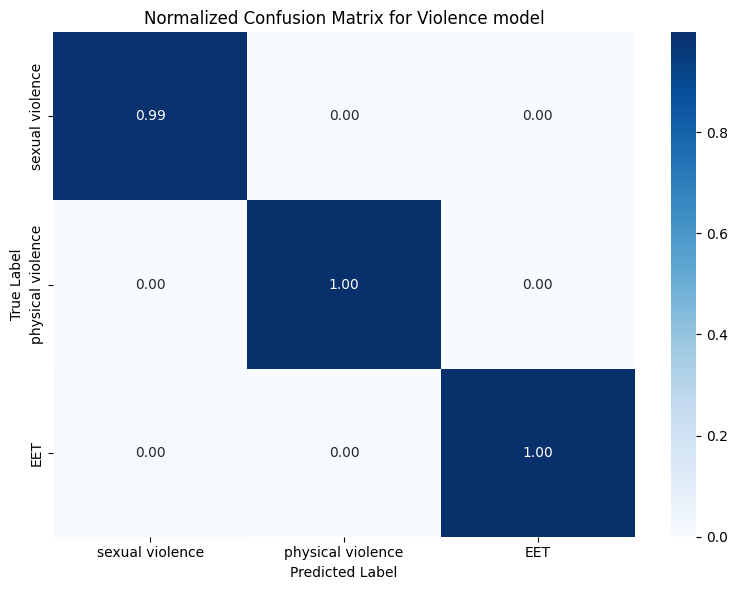

In [22]:
labels = ['sexual violence', 'physical violence', 'EET']

cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix for Violence model')
plt.tight_layout()
plt.show()

In [23]:
model.save_pretrained("models/models/violence_roberta_model")
tokenizer.save_pretrained("models/models/violence_tokenizer")

('models/models/violence_tokenizer\\tokenizer_config.json',
 'models/models/violence_tokenizer\\special_tokens_map.json',
 'models/models/violence_tokenizer\\vocab.json',
 'models/models/violence_tokenizer\\merges.txt',
 'models/models/violence_tokenizer\\added_tokens.json',
 'models/models/violence_tokenizer\\tokenizer.json')